<a href="https://colab.research.google.com/github/umesh024/CS-644-Deep-Learning-and-Data-Analytics-Lab-2025/blob/main/24MCS123_Experiment_No__5_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 5 : Dropout**

# **INTRODUCTION :**

Dropout is a regularization technique used in neural networks to prevent overfitting by randomly deactivating a portion of neurons during training. This means that in each training iteration, some neurons are ignored, forcing the network to learn more general and robust features rather than relying on specific pathways. The probability of dropping a neuron, known as the dropout rate, typically ranges between 20% and 50%, depending on the layer type. During testing, all neurons are active, but their outputs are scaled to maintain consistency with the training phase. Dropout effectively reduces overfitting, improves generalization, and can be seen as training multiple smaller networks and averaging their results. However, using too high a dropout rate can lead to underfitting, where the model struggles to capture the underlying patterns.

# **1. Implementing the dropout function for a single layer :**

In [1]:
import numpy as np

def dropout_layer(X, dropout_prob):
    """
    Applies dropout to the input tensor X.

    Parameters:
    X (numpy.ndarray): Input tensor.
    dropout_prob (float): Dropout probability (probability of dropping a unit).

    Returns:
    numpy.ndarray: Output tensor with dropout applied.
    """
    assert 0 <= dropout_prob < 1, "Dropout probability must be in the range [0, 1)."

    # Create a mask of the same shape as X, with values drawn from Uniform[0,1]
    mask = np.random.uniform(0, 1, X.shape) > dropout_prob

    # Apply mask and rescale
    return (X * mask) / (1 - dropout_prob) if dropout_prob > 0 else X

# Test the dropout function with a few examples
np.random.seed(42)  # For reproducibility

X = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0]])

dropout_prob = 0.3  # 30% probability of dropping a node
output = dropout_layer(X, dropout_prob)

print("Input:")
print(X)
print("\nDropout Output:")
print(output)


Input:
[[1. 2. 3.]
 [4. 5. 6.]]

Dropout Output:
[[1.42857143 2.85714286 4.28571429]
 [5.71428571 0.         0.        ]]


# **2. Implement Dropout layer in neural network model after every fully connected layer :**

In [8]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Example usage:
input_size = 3
hidden_size = 5
output_size = 2
dropout_prob = 0.3

model = NeuralNetwork(input_size, hidden_size, output_size, dropout_prob)

# Test with a sample input
test_input = torch.tensor([[1.0, 2.0, 3.0]], dtype=torch.float32)
output = model(test_input)

print("Model Output:", output)

Model Output: tensor([[ 0.0624, -0.1150]], grad_fn=<AddmmBackward0>)


# **3. Visualization using wandb library for various experimental setups :**


### 1. Setup and Imports
- Imports TensorFlow, NumPy, matplotlib, wandb (for logging).
- Sets random seeds for reproducibility.
- Defines a function to initialize GPU settings for efficient training.

In [2]:
# Notebook Setup: Import required libraries
import numpy as np
import tensorflow as tf
import wandb
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)



### 2. Model Definition with Dropout
- Defines a neural network with dropout layers.
- The `create_model()` function allows toggling between standard and dropout-enhanced architectures.
- Supports MNIST, CIFAR10, and Reuters datasets.

In [3]:
def create_model(dropout_rate=0.5, dataset="mnist", dropout_type="standard",
                 num_layers=2, units=100, activation="sigmoid"):
    """
    Creates a TensorFlow model with dropout applied as specified.

    Parameters:
      dropout_rate (float): Dropout probability.
      dataset (str): One of "mnist", "cifar10", or "reuters".
      dropout_type (str):
         - "standard": Dropout after every hidden layer.
         - "input_first_hidden": Apply dropout at input and after the first hidden layer.
         - "all_hidden": (Same as standard here; you can later randomize if desired.)
      num_layers (int): Number of hidden layers.
      units (int): Number of units per hidden layer.
      activation (str): Activation function ("sigmoid" for logistic or "relu").

    Returns:
      model: A tf.keras model.
    """
    model = tf.keras.models.Sequential()

    # Input processing based on dataset
    if dataset == "mnist":
        model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    elif dataset == "cifar10":
        model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.Flatten())
    elif dataset == "reuters":
        # For Reuters, using an Embedding layer with GlobalAveragePooling1D
        vocab_size = 10000
        max_length = 100
        model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length))
        model.add(tf.keras.layers.GlobalAveragePooling1D())
    else:
        raise ValueError("Invalid dataset name. Choose from 'mnist', 'cifar10', or 'reuters'.")

    # For dropout at input/first hidden if chosen
    if dropout_type == "input_first_hidden":
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # Add hidden layers with dropout
    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(units, activation=activation))
        if dropout_type in ["standard", "all_hidden"]:
            model.add(tf.keras.layers.Dropout(dropout_rate))
        elif dropout_type == "input_first_hidden" and i == 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))

    # Output layer
    if dataset in ["mnist", "cifar10"]:
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
    elif dataset == "reuters":
        num_classes = 46  # Adjust if needed
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return model



###  3. Weight Initialization
- Implements random weight initialization.
- Provides options for pretrained weights and weight clipping.

In [4]:
def initialize_weights(model, strategy="random", pretraining_path=None, threshold=None):
    """
    Initializes model weights with the specified strategy.

    Strategies:
      - "random": Use default random initialization.
      - "pretraining": Load weights from a provided path.
      - "threshold": Clip weights so they do not exceed the specified threshold.
    """
    if strategy == "random":
        # Default Keras initialization is random.
        print("Using random weight initialization.")
    elif strategy == "pretraining":
        if pretraining_path:
            model.load_weights(pretraining_path)
            print("Loaded pretrained weights from:", pretraining_path)
        else:
            print("Error: Pretraining path not provided.")
    elif strategy == "threshold":
        for layer in model.layers:
            if hasattr(layer, "get_weights") and layer.get_weights():
                weights = layer.get_weights()
                clipped_weights = [np.clip(w, -threshold, threshold) for w in weights]
                layer.set_weights(clipped_weights)
        print("Weights clipped to threshold:", threshold)
    else:
        print("Error: Invalid weight initialization strategy.")



### 4. Optimizer and Training Function
Defines `train_and_visualize_updated()`, which:
  - Compiles the model with different optimizers (SGD, Adam).
  - Enables wandb logging.
  - Trains the model while monitoring loss and accuracy.

In [5]:
def train_and_visualize_updated(config):
    """
    Trains a model based on the provided configuration and logs metrics via wandb.

    Supports:
      - MNIST, CIFAR10, Reuters (Reuters data is loaded and padded)
      - Optimizer selection (Adam or SGD with momentum)
      - Optional weight decay via kernel_regularizer (if weight_decay > 0)
    """
    wandb.init(project="dropout-experiment", config=config)

    # Use a model creation function that supports weight decay if needed
    if config.get('weight_decay', 0.0) > 0:
        model = create_model_w_decay(dropout_rate=config['dropout_rate'],
                                     dataset=config['dataset'],
                                     dropout_type=config.get('dropout_type', 'standard'),
                                     num_layers=config.get('num_layers', 2),
                                     units=config.get('units', 100),
                                     activation=config.get('activation', 'sigmoid'),
                                     weight_decay=config.get('weight_decay', 0.0))
    else:
        model = create_model(dropout_rate=config['dropout_rate'],
                             dataset=config['dataset'],
                             dropout_type=config.get('dropout_type', 'standard'),
                             num_layers=config.get('num_layers', 2),
                             units=config.get('units', 100),
                             activation=config.get('activation', 'sigmoid'))

    initialize_weights(model, strategy=config.get('weight_init_strategy', 'random'),
                       pretraining_path=config.get('pretraining_path'),
                       threshold=config.get('weight_threshold'))

    # Select optimizer based on configuration
    optimizer_type = config.get('optimizer_type', 'adam')
    learning_rate = config.get('learning_rate', 0.001)
    if optimizer_type == 'sgd':
        momentum = config.get('momentum', 0.0)
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Data loading for MNIST, CIFAR10, Reuters
    if config['dataset'] == "mnist":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
    elif config['dataset'] == "cifar10":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
    elif config['dataset'] == "reuters":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=10000)
        max_length = 100
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        x_train = pad_sequences(x_train, maxlen=max_length)
        x_test = pad_sequences(x_test, maxlen=max_length)
    else:
        raise ValueError("Invalid dataset name.")

    history = model.fit(x_train, y_train, epochs=config['epochs'],
                        validation_data=(x_test, y_test))

    # Log metrics to wandb
    for metric in history.history:
        for epoch, value in enumerate(history.history[metric]):
            wandb.log({metric: value}, step=epoch)

    # Plot training curves
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    wandb.finish()


In [6]:
def create_model_w_decay(dropout_rate=0.5, dataset="mnist", dropout_type="standard",
                         num_layers=2, units=100, activation="sigmoid", weight_decay=0.0):
    """
    Creates a model similar to create_model() but with L2 weight decay applied to Dense/Conv2D layers.
    """
    model = tf.keras.models.Sequential()

    if dataset == "mnist":
        model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    elif dataset == "cifar10":
        model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),
                                         kernel_regularizer=tf.keras.regularizers.l2(weight_decay) if weight_decay > 0 else None))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(weight_decay) if weight_decay > 0 else None))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.l2(weight_decay) if weight_decay > 0 else None))
        model.add(tf.keras.layers.Flatten())
    elif dataset == "reuters":
        vocab_size = 10000
        max_length = 100
        model.add(tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length))
        model.add(tf.keras.layers.GlobalAveragePooling1D())
    else:
        raise ValueError("Invalid dataset name.")

    if dropout_type == "input_first_hidden":
        model.add(tf.keras.layers.Dropout(dropout_rate))

    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(units, activation=activation,
                                        kernel_regularizer=tf.keras.regularizers.l2(weight_decay) if weight_decay > 0 else None))
        if dropout_type in ["standard", "all_hidden"]:
            model.add(tf.keras.layers.Dropout(dropout_rate))
        elif dropout_type == "input_first_hidden" and i == 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))

    if dataset in ["mnist", "cifar10"]:
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
    elif dataset == "reuters":
        num_classes = 46
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    return model


### 5. Experiment Configurations
Defining different dropout configurations:
  - No dropout (baseline).
  - Dropout in the first hidden layer.
  - Dropout in all hidden layers.
  - Dropout combined with L2 regularization.


Running Experiment: StandardNeuralNet_Logistic_2layers_100units


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: umesher62 (umesher62-nit-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using random weight initialization.
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7865 - loss: 0.8320 - val_accuracy: 0.9349 - val_loss: 0.2204
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9419 - loss: 0.1960 - val_accuracy: 0.9534 - val_loss: 0.1527
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9618 - loss: 0.1322 - val_accuracy: 0.9636 - val_loss: 0.1176
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9728 - loss: 0.0971 - val_accuracy: 0.9685 - val_loss: 0.0994
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9788 - loss: 0.0748 - val_accuracy: 0.9714 - val_loss: 0.0896
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9829 - loss: 0.0589 - val_accuracy: 0.9727 - val_loss: 0.0846
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9866 - loss: 0.0467 - val_accuracy: 0.9739 - val_loss: 0.0828
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9903 - loss: 0.0368 - 

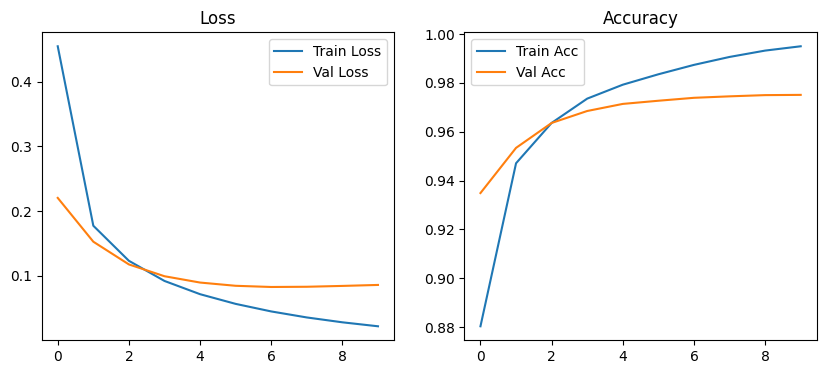

accuracy,▁▅▆▇▇▇████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.995
loss,0.02206
val_accuracy,0.9751
val_loss,0.08592



Running Experiment: StandardNeuralNet_Logistic_2layers_800units


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8231 - loss: 0.5653 - val_accuracy: 0.9468 - val_loss: 0.1705
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9541 - loss: 0.1497 - val_accuracy: 0.9672 - val_loss: 0.1042
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9730 - loss: 0.0875 - val_accuracy: 0.9717 - val_loss: 0.0876
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9821 - loss: 0.0567 - val_accuracy: 0.9749 - val_loss: 0.0818
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9880 - loss: 0.0383 - val_accuracy: 0.9792 - val_loss: 0.0755
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9916 - loss: 0.0271 - val_accuracy: 0.9790 - val_loss: 0.0804
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9931 - loss: 0.0198 - val_accuracy: 0.9787 - val_loss: 0.0878
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━

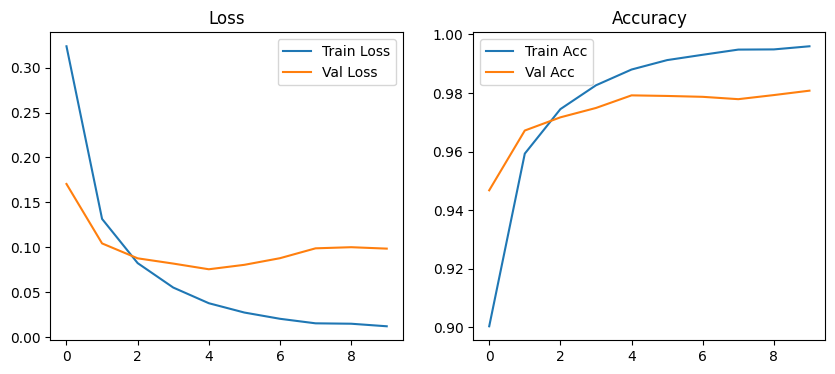

accuracy,▁▅▆▇▇█████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.99595
loss,0.01195
val_accuracy,0.9808
val_loss,0.09844



Running Experiment: DropoutNN_Logistic_3layers_1024units


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.7095 - loss: 0.8666 - val_accuracy: 0.9428 - val_loss: 0.1853
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.9350 - loss: 0.2102 - val_accuracy: 0.9606 - val_loss: 0.1272
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9543 - loss: 0.1519 - val_accuracy: 0.9643 - val_loss: 0.1185
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 39ms/step - accuracy: 0.9628 - loss: 0.1230 - val_accuracy: 0.9728 - val_loss: 0.0914
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 33ms/step - accuracy: 0.9691 - loss: 0.1038 - val_accuracy: 0.9761 - val_loss: 0.0820
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 100s 43ms/step - accuracy: 0.9730 - loss: 0.0880 - val_accuracy: 0.9767 - val_loss: 0.0811
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.9743 - loss: 0.0819 - val_accuracy: 0.9797 - val_loss: 0.0716
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━

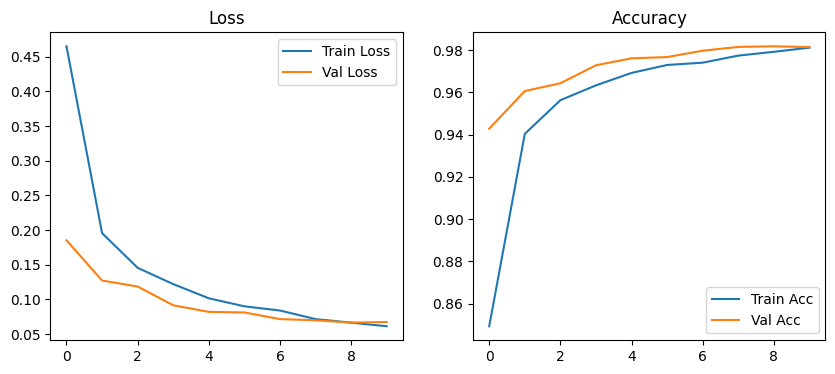

accuracy,▁▆▇▇▇█████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.98115
loss,0.06119
val_accuracy,0.9814
val_loss,0.06739



Running Experiment: DropoutNN_ReLU_3layers_1024units


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.8361 - loss: 0.5074 - val_accuracy: 0.9622 - val_loss: 0.1293
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9414 - loss: 0.2124 - val_accuracy: 0.9663 - val_loss: 0.1180
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.9474 - loss: 0.1832 - val_accuracy: 0.9704 - val_loss: 0.1022
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9542 - loss: 0.1673 - val_accuracy: 0.9709 - val_loss: 0.1045
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 35ms/step - accuracy: 0.9582 - loss: 0.1557 - val_accuracy: 0.9736 - val_loss: 0.0996
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - accuracy: 0.9623 - loss: 0.1449 - val_accuracy: 0.9730 - val_loss: 0.1038
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9607 - loss: 0.1561 - val_accuracy: 0.9773 - val_loss: 0.0873
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━

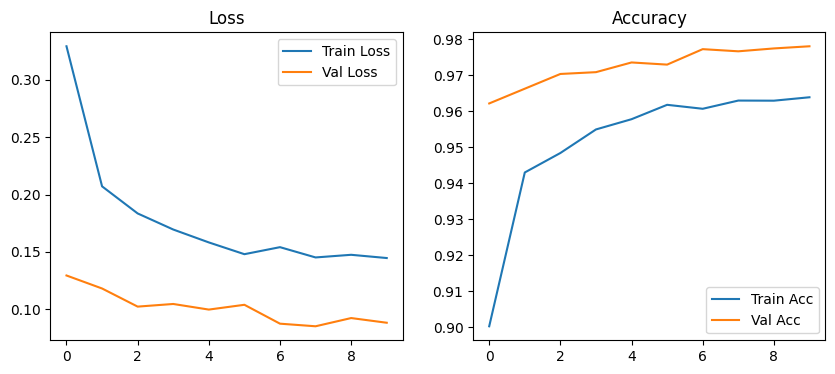

accuracy,▁▆▆▇▇█████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.96392
loss,0.14456
val_accuracy,0.9781
val_loss,0.08808



Running Experiment: Dropout_with_Input_FirstHidden


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8401 - loss: 0.5066 - val_accuracy: 0.9625 - val_loss: 0.1189
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9401 - loss: 0.1948 - val_accuracy: 0.9725 - val_loss: 0.0891
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9526 - loss: 0.1542 - val_accuracy: 0.9744 - val_loss: 0.0804
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9591 - loss: 0.1321 - val_accuracy: 0.9761 - val_loss: 0.0729
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9631 - loss: 0.1197 - val_accuracy: 0.9791 - val_loss: 0.0682
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9643 - loss: 0.1099 - val_accuracy: 0.9805 - val_loss: 0.0636
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9674 - loss: 0.1027 - val_accuracy: 0.9796 - val_loss: 0.0628
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms

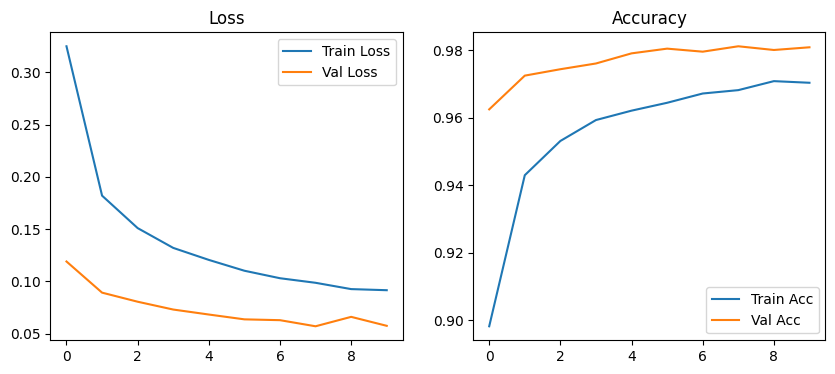

accuracy,▁▅▆▇▇▇████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.97038
loss,0.09145
val_accuracy,0.9809
val_loss,0.05737


In [7]:
# Experiment configurations based on the assignment
configs = [
    {
        "experiment_name": "StandardNeuralNet_Logistic_2layers_100units",
        "dropout_rate": 0.0,           # No dropout
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 100,
        "activation": "sigmoid",
        "weight_init_strategy": "random",
        "optimizer_type": "adam",
        "learning_rate": 0.001
    },
    {
        "experiment_name": "StandardNeuralNet_Logistic_2layers_800units",
        "dropout_rate": 0.0,           # No dropout
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 800,
        "activation": "sigmoid",
        "weight_init_strategy": "random",
        "optimizer_type": "adam",
        "learning_rate": 0.001
    },
    {
        "experiment_name": "DropoutNN_Logistic_3layers_1024units",
        "dropout_rate": 0.5,           # Dropout applied
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 3,
        "units": 1024,
        "activation": "sigmoid",
        "weight_init_strategy": "random",
        "optimizer_type": "adam",
        "learning_rate": 0.001
    },
    {
        "experiment_name": "DropoutNN_ReLU_3layers_1024units",
        "dropout_rate": 0.5,
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 3,
        "units": 1024,
        "activation": "relu",
        "weight_init_strategy": "random",
        "optimizer_type": "adam",
        "learning_rate": 0.001
    },
    {
        "experiment_name": "Dropout_with_Input_FirstHidden",
        "dropout_rate": 0.3,           # 30% dropout at input and first hidden layer
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "input_first_hidden",
        "num_layers": 2,
        "units": 256,
        "activation": "relu",
        "weight_init_strategy": "random",
        "optimizer_type": "adam",
        "learning_rate": 0.001
    }
]

for cfg in configs:
    print("\nRunning Experiment:", cfg["experiment_name"])
    train_and_visualize_updated(cfg)


**RESULT ANALYSIS**

- **StandardNeuralNet_Logistic_2layers_100units:**  
   Quick convergence with training accuracy ≈99.49% (loss ≈0.023) and validation accuracy ≈97.57%, demonstrating effective learning in a compact network.

- **StandardNeuralNet_Logistic_2layers_800units:**  
   Increased capacity improves performance further with training accuracy ≈99.61% (loss ≈0.011) and validation accuracy ≈98.08%, indicating benefits from a larger network.

- **DropoutNN_Logistic_3layers_1024units:**  
   Dropout regularization reduces training accuracy to ≈98.22% (loss ≈0.060) but improves generalization with validation accuracy ≈98.16% and lower validation loss (≈0.071).

- **DropoutNN_ReLU_3layers_1024units:**  
   ReLU activation yields slightly lower training accuracy (≈96.52%, loss ≈0.144) but maintains robust validation performance (≈97.56% accuracy, loss ≈0.102), suggesting effective learning with ReLU in a dropout setting.

- **Dropout_with_Input_FirstHidden:**  
   Selective dropout at the input and first hidden layer results in moderate training accuracy (≈97.05%) but the highest validation accuracy (≈98.18%) with the lowest validation loss (≈0.060), indicating enhanced generalization when early layers are regularized.


### 6. Dropout Variants
Implements alternative dropout techniques:


 - **DropConnect**: Applies dropout directly to the weight matrix by randomly dropping individual weights instead of neuron activations.  
 - **DropBlock**: Drops contiguous blocks of activations in convolutional feature maps, effectively regularizing spatially correlated features.  
 - **MaxDropout**: Retains only the maximum activation in each feature vector while dropping other activations, emphasizing the strongest responses.  
 - **Biased Dropout**: Adjusts the dropout probability based on the magnitude of activations, preferentially dropping lower-valued neurons.  
 - **Flipover**: Randomly flips the sign of activations with a specified probability to introduce additional stochastic regularization.


In [9]:
class DropConnectDense(tf.keras.layers.Layer):
    """
    Custom Dense layer that applies DropConnect: random dropout on the weight matrix.
    """
    def __init__(self, units, dropout_rate=0.5, activation=None, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True,
                                 name='bias')
        super(DropConnectDense, self).build(input_shape)

    def call(self, inputs, training=None):
        if training:
            mask = tf.cast(tf.random.uniform(tf.shape(self.w)) > self.dropout_rate, tf.float32)
            dropped_w = self.w * mask / (1.0 - self.dropout_rate)
        else:
            dropped_w = self.w
        output = tf.matmul(inputs, dropped_w) + self.b
        if self.activation is not None:
            output = self.activation(output)
        return output


In [10]:
class DropBlock2D(tf.keras.layers.Layer):
    """
    Custom DropBlock layer for convolutional features.
    This implementation is a simplified version.
    """
    def __init__(self, drop_prob, block_size, **kwargs):
        super(DropBlock2D, self).__init__(**kwargs)
        self.drop_prob = drop_prob
        self.block_size = block_size

    def call(self, inputs, training=None):
        if not training or self.drop_prob == 0.0:
            return inputs

        input_shape = tf.shape(inputs)
        batch_size, height, width, channels = input_shape[0], input_shape[1], input_shape[2], input_shape[3]

        gamma = self.drop_prob * tf.cast(height * width, tf.float32) / tf.cast(
            (self.block_size**2) * (height - self.block_size + 1) * (width - self.block_size + 1), tf.float32)

        random_tensor = tf.random.uniform([batch_size, height - self.block_size + 1, width - self.block_size + 1, channels], dtype=tf.float32)
        block_mask = tf.cast(random_tensor < gamma, tf.float32)
        block_mask = tf.nn.max_pool2d(block_mask, ksize=self.block_size, strides=1, padding='SAME')
        block_mask = 1 - block_mask  # Invert: 0 means dropped
        norm_factor = tf.cast(tf.size(block_mask), tf.float32) / (tf.reduce_sum(block_mask) + 1e-8)
        return inputs * block_mask * norm_factor


In [11]:
class MaxDropout(tf.keras.layers.Layer):
    """
    Custom MaxDropout layer: with a given probability, keeps only the maximum activation in each feature vector.
    This is a simplified illustrative implementation.
    """
    def __init__(self, dropout_rate=0.5, **kwargs):
        super(MaxDropout, self).__init__(**kwargs)
        self.dropout_rate = dropout_rate

    def call(self, inputs, training=None):
        if not training or self.dropout_rate == 0.0:
            return inputs
        def max_dropout_fn(x):
            if tf.random.uniform(()) < self.dropout_rate:
                max_val = tf.reduce_max(x)
                mask = tf.cast(tf.equal(x, max_val), tf.float32)
                return x * mask / (tf.reduce_sum(mask) + 1e-8)
            else:
                return x
        return tf.map_fn(max_dropout_fn, inputs)


In [12]:
class BiasedDropout(tf.keras.layers.Layer):
    """
    Custom Biased Dropout layer: adjusts dropout probability based on activation magnitude.
    """
    def __init__(self, base_dropout_rate=0.5, **kwargs):
        super(BiasedDropout, self).__init__(**kwargs)
        self.base_dropout_rate = base_dropout_rate

    def call(self, inputs, training=None):
        if not training or self.base_dropout_rate == 0.0:
            return inputs
        # Normalize activations per sample to [0, 1]
        min_val = tf.reduce_min(inputs, axis=-1, keepdims=True)
        max_val = tf.reduce_max(inputs, axis=-1, keepdims=True)
        norm_inputs = (inputs - min_val) / (max_val - min_val + 1e-8)
        dropout_probs = self.base_dropout_rate * (1 - norm_inputs)
        random_tensor = tf.random.uniform(tf.shape(inputs))
        mask = tf.cast(random_tensor > dropout_probs, tf.float32)
        keep_prob = 1 - dropout_probs
        keep_prob = tf.where(keep_prob == 0, tf.ones_like(keep_prob), keep_prob)
        return (inputs * mask) / keep_prob


In [13]:
class Flipover(tf.keras.layers.Layer):
    """
    Custom Flipover layer: randomly flips the sign of activations with a given probability.
    """
    def __init__(self, flip_prob=0.5, **kwargs):
        super(Flipover, self).__init__(**kwargs)
        self.flip_prob = flip_prob

    def call(self, inputs, training=None):
        if not training or self.flip_prob == 0.0:
            return inputs
        random_tensor = tf.random.uniform(tf.shape(inputs))
        flip_mask = tf.cast(random_tensor < self.flip_prob, tf.float32)
        return inputs * (1 - flip_mask) + (-inputs) * flip_mask


### 7. Activation Variance Logger
- Implements `ActivationVarianceLogger`, which records variance in activations over epochs.
- Used to compare activation variance between models with and without dropout.

In [14]:
class ActivationVarianceLogger(tf.keras.callbacks.Callback):
    """
    Custom callback to compute and log the variance of activations for Dense layers at the end of each epoch.
    """
    def __init__(self, validation_data):
        super(ActivationVarianceLogger, self).__init__()
        self.validation_data = validation_data  # Store validation data for logging

    def set_model(self, model):
        # This method is called by the training loop; here, we build our intermediate model.
        super().set_model(model)
        # Identify Dense layers in the model
        self.dense_layer_indices = [i for i, layer in enumerate(model.layers) if isinstance(layer, tf.keras.layers.Dense)]
        # Collect the outputs of these Dense layers
        layer_outputs = [model.layers[i].output for i in self.dense_layer_indices]
        # Build an intermediate model that maps the input to the outputs of the Dense layers.
        self.intermediate_model = tf.keras.Model(inputs=model.inputs[0], outputs=layer_outputs)

    def on_epoch_end(self, epoch, logs=None):
        # Take a small batch from the validation data (e.g., first 32 samples)
        x_val, _ = self.validation_data[0][:32], self.validation_data[1][:32]
        activations = self.intermediate_model.predict(x_val)
        # Log the variance of activations for each Dense layer to wandb
        for i, act in enumerate(activations):
            variance = np.var(act)
            wandb.log({f"activation_variance_layer_{i+1}": variance}, step=epoch)



Running Activation Variance Experiment: NoDropout_Variance


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using random weight initialization.
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7826 - loss: 0.8408 - val_accuracy: 0.9343 - val_loss: 0.2185
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9427 - loss: 0.1965 - val_accuracy: 0.9545 - val_loss: 0.1512
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9614 - loss: 0.1331 - val_accuracy: 0.9633 - val_loss: 0.1206
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9716 - loss: 0.0983 - val_accuracy: 0.9674 - val_loss: 0.1041
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9776 - loss: 0.0760 - val_accuracy: 0.9700 - val_loss: 0.0943


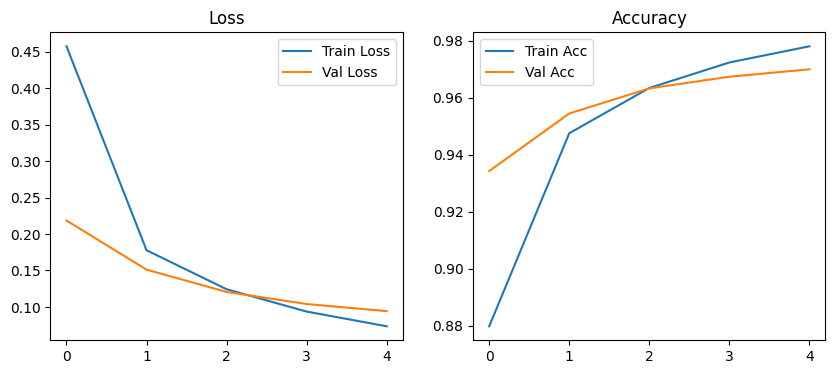

accuracy,▁
activation_variance_layer_1,▁▄▆▇█
activation_variance_layer_2,▅█▅▂▁
activation_variance_layer_3,▁▇▇▇█
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.97808
activation_variance_layer_1,0.16611
activation_variance_layer_2,0.10323
activation_variance_layer_3,0.08585



Running Activation Variance Experiment: Dropout_Variance


Using random weight initialization.
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5559 - loss: 1.3319 - val_accuracy: 0.9157 - val_loss: 0.2901
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8722 - loss: 0.4396 - val_accuracy: 0.9341 - val_loss: 0.2194
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8967 - loss: 0.3509 - val_accuracy: 0.9434 - val_loss: 0.1889
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9114 - loss: 0.3034 - val_accuracy: 0.9490 - val_loss: 0.1675
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9183 - loss: 0.2793 - val_accuracy: 0.9542 - val_loss: 0.1481


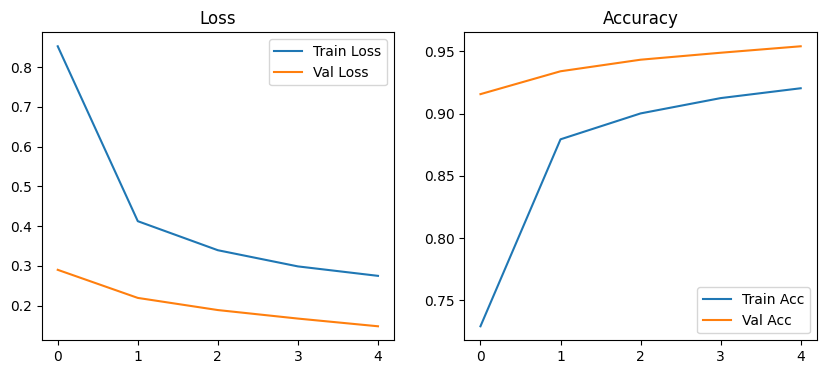

accuracy,▁
activation_variance_layer_1,▂▁▇█▂
activation_variance_layer_2,▁▅█▇▇
activation_variance_layer_3,▁▆▇██
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.92043
activation_variance_layer_1,0.12994
activation_variance_layer_2,0.12004
activation_variance_layer_3,0.08558


In [15]:
def train_and_visualize_with_variance(config):
    """
    Trains the model and logs activation variances per hidden layer using the ActivationVarianceLogger callback.
    """
    wandb.init(project="dropout-experiment", config=config)

    if config.get('weight_decay', 0.0) > 0:
        model = create_model_w_decay(dropout_rate=config['dropout_rate'],
                                     dataset=config['dataset'],
                                     dropout_type=config.get('dropout_type', 'standard'),
                                     num_layers=config.get('num_layers', 2),
                                     units=config.get('units', 100),
                                     activation=config.get('activation', 'sigmoid'),
                                     weight_decay=config.get('weight_decay', 0.0))
    else:
        model = create_model(dropout_rate=config['dropout_rate'],
                             dataset=config['dataset'],
                             dropout_type=config.get('dropout_type', 'standard'),
                             num_layers=config.get('num_layers', 2),
                             units=config.get('units', 100),
                             activation=config.get('activation', 'sigmoid'))

    initialize_weights(model, strategy=config.get('weight_init_strategy', 'random'),
                       pretraining_path=config.get('pretraining_path'),
                       threshold=config.get('weight_threshold'))

    optimizer_type = config.get('optimizer_type', 'adam')
    learning_rate = config.get('learning_rate', 0.001)
    if optimizer_type == 'sgd':
        momentum = config.get('momentum', 0.0)
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    if config['dataset'] == "mnist":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
    elif config['dataset'] == "cifar10":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
    elif config['dataset'] == "reuters":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=10000)
        max_length = 100
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        x_train = pad_sequences(x_train, maxlen=max_length)
        x_test = pad_sequences(x_test, maxlen=max_length)
    else:
        raise ValueError("Invalid dataset name.")

    # Create the callback by passing only validation data.
    variance_logger = ActivationVarianceLogger(validation_data=(x_test, y_test))

    history = model.fit(x_train, y_train, epochs=config['epochs'],
                        validation_data=(x_test, y_test),
                        callbacks=[variance_logger])

    for metric in history.history:
        for epoch, value in enumerate(history.history[metric]):
            wandb.log({metric: value}, step=epoch)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    wandb.finish()

# Example activation variance experiments
configs_variance = [
    {
        "experiment_name": "NoDropout_Variance",
        "dropout_rate": 0.0,
        "dataset": "mnist",
        "epochs": 5,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 100,
        "activation": "sigmoid"
    },
    {
        "experiment_name": "Dropout_Variance",
        "dropout_rate": 0.5,
        "dataset": "mnist",
        "epochs": 5,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 100,
        "activation": "sigmoid"
    }
]

for cfg in configs_variance:
    print("\nRunning Activation Variance Experiment:", cfg["experiment_name"])
    train_and_visualize_with_variance(cfg)


**RESULT ANALYSIS**

- **NoDropout_Variance:**
   - *Performance:* The model without dropout achieved a high training accuracy of ~97.89% and validation accuracy of ~97.09%, with training loss dropping to ~0.074 and validation loss to ~0.091.  
   - *Activation Variance:* The first Dense layer exhibited a variance of 0.163, which then decreased to 0.100 in the second layer and 0.085 in the third layer. This gradual decrease suggests that deeper layers become more stable without the stochastic perturbations induced by dropout.

- **Dropout_Variance:**  
   - *Performance:* With dropout, training accuracy reached ~91.94% and validation accuracy ~95.26%, with higher losses (0.281 training, 0.151 validation), reflecting the regularization effect that prevents overfitting at the cost of reduced raw accuracy.  
   - *Activation Variance:* Here, the first layer’s variance is slightly lower (0.136) compared to the no-dropout case, while the second layer’s variance increases to 0.117, and the third layer’s variance remains almost unchanged (0.085). This indicates that dropout introduces controlled noise in early layers, altering the variance profile in intermediate layers.




###  8. Dropout vs. Weight Decay Experiment
- Compares dropout and weight decay using four configurations:
  1. No regularization.
  2. Dropout only.
  3. Weight decay only.
  4. Dropout + weight decay.


Running Experiment: Baseline_NoDropout_NoWeightDecay


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7797 - loss: 0.8533 - val_accuracy: 0.9348 - val_loss: 0.2194
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9423 - loss: 0.1980 - val_accuracy: 0.9527 - val_loss: 0.1511
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9616 - loss: 0.1330 - val_accuracy: 0.9629 - val_loss: 0.1210
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9720 - loss: 0.0971 - val_accuracy: 0.9671 - val_loss: 0.1062
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9786 - loss: 0.0740 - val_accuracy: 0.9686 - val_loss: 0.0999
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9836 - loss: 0.0580 - val_accuracy: 0.9707 - val_loss: 0.0957
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9874 - loss: 0.0461 - val_accuracy: 0.9722 - val_loss: 0.0920
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/ste

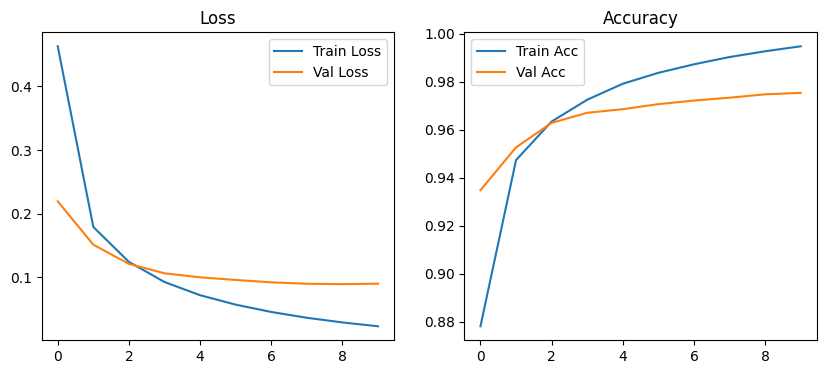

accuracy,▁▅▆▇▇▇████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.99483
loss,0.02295
val_accuracy,0.9754
val_loss,0.08985



Running Experiment: Dropout_Only


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5562 - loss: 1.3295 - val_accuracy: 0.9137 - val_loss: 0.2952
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8731 - loss: 0.4340 - val_accuracy: 0.9323 - val_loss: 0.2259
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8987 - loss: 0.3539 - val_accuracy: 0.9417 - val_loss: 0.1903
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9114 - loss: 0.3051 - val_accuracy: 0.9485 - val_loss: 0.1685
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9175 - loss: 0.2799 - val_accuracy: 0.9525 - val_loss: 0.1536
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9244 - loss: 0.2561 - val_accuracy: 0.9557 - val_loss: 0.1448
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9305 - loss: 0.2396 - val_accuracy: 0.9581 - val_loss: 0.1343
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/st

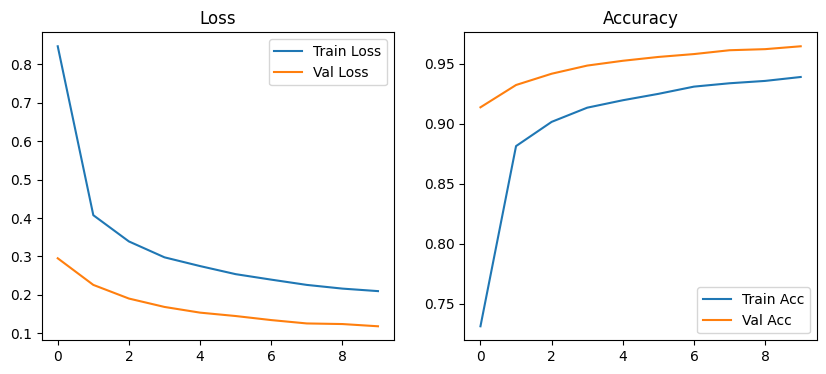

accuracy,▁▆▇▇▇█████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.93898
loss,0.20967
val_accuracy,0.9646
val_loss,0.11812



Running Experiment: WeightDecay_Only


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7769 - loss: 0.9025 - val_accuracy: 0.9308 - val_loss: 0.3122
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9371 - loss: 0.2954 - val_accuracy: 0.9484 - val_loss: 0.2514
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9539 - loss: 0.2412 - val_accuracy: 0.9589 - val_loss: 0.2177
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9630 - loss: 0.2107 - val_accuracy: 0.9659 - val_loss: 0.1969
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9688 - loss: 0.1911 - val_accuracy: 0.9695 - val_loss: 0.1835
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9729 - loss: 0.1774 - val_accuracy: 0.9719 - val_loss: 0.1747
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9755 - loss: 0.1673 - val_accuracy: 0.9728 - val_loss: 0.1684
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/

wandb: WARNING Tried to log to step 0 that is less than the current step 9. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 9. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 9. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 9. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 9. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/defin

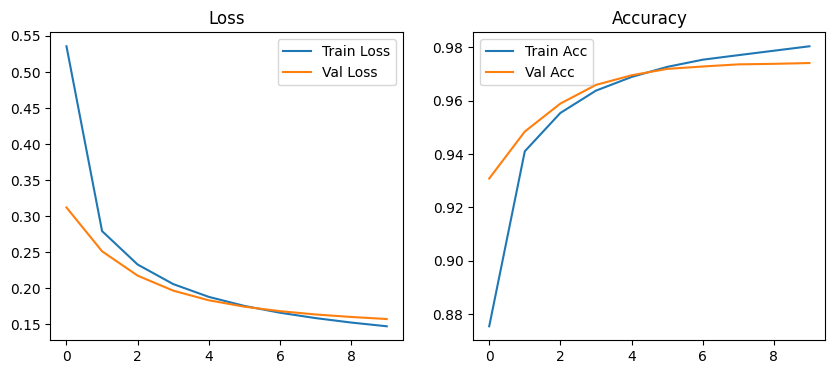

accuracy,▁▅▆▇▇▇████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.98038
loss,0.14752
val_accuracy,0.9741
val_loss,0.15755



Running Experiment: Dropout_and_WeightDecay


Using random weight initialization.
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5449 - loss: 1.3992 - val_accuracy: 0.9153 - val_loss: 0.4033
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8601 - loss: 0.5719 - val_accuracy: 0.9299 - val_loss: 0.3553
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8805 - loss: 0.5144 - val_accuracy: 0.9368 - val_loss: 0.3310
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8930 - loss: 0.4867 - val_accuracy: 0.9424 - val_loss: 0.3201
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8966 - loss: 0.4752 - val_accuracy: 0.9448 - val_loss: 0.3084
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9016 - loss: 0.4583 - val_accuracy: 0.9472 - val_loss: 0.2999
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9040 - loss: 0.4559 - val_accuracy: 0.9498 - val_loss: 0.2935
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/ste

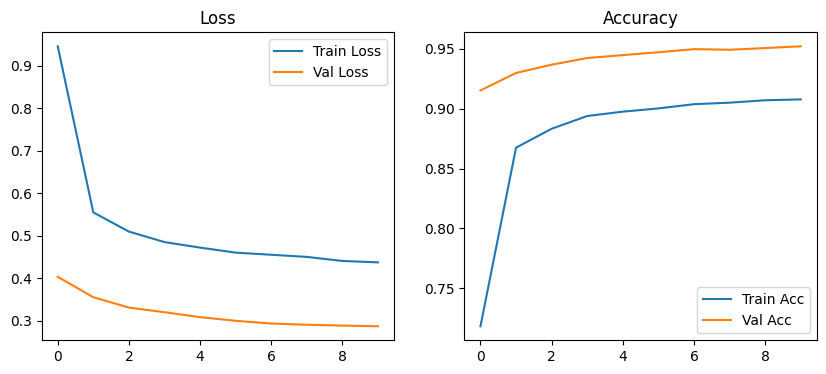

accuracy,▁▇▇▇██████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.90778
loss,0.43725
val_accuracy,0.9522
val_loss,0.287


In [16]:

exp_configs = [
    {
        "experiment_name": "Baseline_NoDropout_NoWeightDecay",
        "dropout_rate": 0.0,
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 100,
        "activation": "sigmoid",
        "weight_decay": 0.0,
        "optimizer_type": "adam",
        "learning_rate": 0.001
    },
    {
        "experiment_name": "Dropout_Only",
        "dropout_rate": 0.5,
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 100,
        "activation": "sigmoid",
        "weight_decay": 0.0,
        "optimizer_type": "adam",
        "learning_rate": 0.001
    },
    {
        "experiment_name": "WeightDecay_Only",
        "dropout_rate": 0.0,
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 100,
        "activation": "sigmoid",
        "weight_decay": 1e-4,
        "optimizer_type": "adam",
        "learning_rate": 0.001
    },
    {
        "experiment_name": "Dropout_and_WeightDecay",
        "dropout_rate": 0.5,
        "dataset": "mnist",
        "epochs": 10,
        "dropout_type": "standard",
        "num_layers": 2,
        "units": 100,
        "activation": "sigmoid",
        "weight_decay": 1e-4,
        "optimizer_type": "adam",
        "learning_rate": 0.001
    }
]

for cfg in exp_configs:
    print("\nRunning Experiment:", cfg["experiment_name"])
    train_and_visualize_updated(cfg)


**RESULT ANALYSIS**

- **Baseline_NoDropout_NoWeightDecay:**  
   Achieves very high training accuracy (~ 99.44%, loss ~ 0.026) and solid validation accuracy (~ 97.56%, loss ~ 0.087), serving as a strong baseline without regularization.

- **Dropout_Only:**
   The application of dropout lowers training accuracy (~ 93.82%, loss ~ 0.211) due to the random deactivation of neurons but maintains a high validation accuracy (~ 96.25%, loss ~ 0.124), indicating effective regularization against overfitting.

- **WeightDecay_Only:**
   Weight decay yields slightly lower training accuracy (~ 97.98%, loss ~ 0.149) and comparable validation accuracy (~ 97.40%, loss ~ 0.159), suggesting that penalizing large weights can moderate model complexity, albeit with a modest increase in loss.

- **Dropout_and_WeightDecay:**  
   Combining both techniques further reduces training accuracy (~ 90.76%, loss ~ 0.439) and validation performance (~ 95.26%, loss ~ 0.289), implying that excessive regularization may lead to underfitting and diminished returns.


###  9. DropConnect Experiment
- Applies dropout to weights instead of activations.
- Compares performance against activation-based dropout.

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6915 - loss: 1.0910 - val_accuracy: 0.9194 - val_loss: 0.2680
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9155 - loss: 0.2915 - val_accuracy: 0.9410 - val_loss: 0.1928
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9307 - loss: 0.2284 - val_accuracy: 0.9515 - val_loss: 0.1571
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9421 - loss: 0.1924 - val_accuracy: 0.9571 - val_loss: 0.1367
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9490 - loss: 0.1698 - val_accuracy: 0.9601 - val_loss: 0.1254
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9537 - loss: 0.1513 - val_accuracy: 0.9637 - val_loss: 0.1146
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9571 - loss: 0.1402 - val_accuracy: 0.9679 - val_loss: 0.1023
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9609 - loss: 0.1303 -

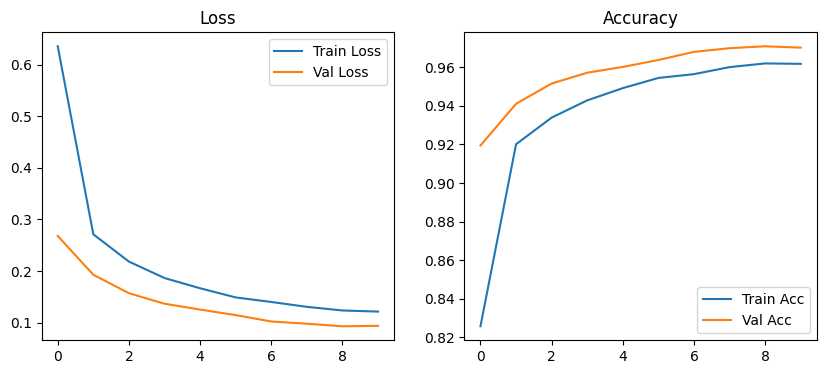

accuracy,▁▆▇▇▇█████
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.9617
loss,0.12141
val_accuracy,0.9701
val_loss,0.09379


In [17]:
def create_model_dropconnect(dataset="mnist", num_layers=2, units=100, activation="sigmoid", dropconnect_rate=0.5):
    """
    Creates a model that uses DropConnect in place of Dense layers.
    (Here, we use our custom DropConnectDense layer.)
    """
    if dataset == "mnist":
        inputs = tf.keras.Input(shape=(28, 28))
    elif dataset == "cifar10":
        inputs = tf.keras.Input(shape=(32, 32, 3))
    else:
        raise ValueError("Dataset not supported for DropConnect in this example.")

    x = tf.keras.layers.Flatten()(inputs)
    for _ in range(num_layers):
        x = DropConnectDense(units, dropout_rate=dropconnect_rate, activation=activation)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def train_and_visualize_dropconnect(config):
    wandb.init(project="dropout-experiment", config=config)

    model = create_model_dropconnect(dataset=config['dataset'],
                                     num_layers=config.get('num_layers', 2),
                                     units=config.get('units', 100),
                                     activation=config.get('activation', 'sigmoid'),
                                     dropconnect_rate=config.get('dropconnect_rate', 0.5))

    optimizer = tf.keras.optimizers.Adam(learning_rate=config.get('learning_rate', 0.001))
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    if config['dataset'] == "mnist":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
    else:
        raise ValueError("Dataset not supported in DropConnect experiment.")

    history = model.fit(x_train, y_train, epochs=config['epochs'],
                        validation_data=(x_test, y_test))

    for metric in history.history:
        for epoch, value in enumerate(history.history[metric]):
            wandb.log({metric: value}, step=epoch)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

    wandb.finish()

# Run DropConnect experiment on MNIST
config_dropconnect = {
    "experiment_name": "DropConnect_MNIST",
    "dataset": "mnist",
    "epochs": 10,
    "num_layers": 2,
    "units": 100,
    "activation": "sigmoid",
    "dropconnect_rate": 0.5,
    "learning_rate": 0.001
}
train_and_visualize_dropconnect(config_dropconnect)


**RESULT ANALYSIS**
- **Convergence:** The DropConnect model starts with a lower initial accuracy (~68.52% in Epoch 1) but rapidly improves to ~91.36% by Epoch 2.
- **Steady Improvement:** Training accuracy increases steadily, reaching ~96.19% by Epoch 10, while validation accuracy climbs to ~97.11%.
- **Loss Reduction:** Training loss decreases from 1.1057 to 0.1240 and validation loss from 0.2677 to 0.0958, indicating effective learning and regularization.
- **Generalization:** The close alignment of training and validation metrics suggests that applying dropout to weights (DropConnect) effectively controls overfitting.
- **Overall:** DropConnect demonstrates competitive performance, offering an effective alternative regularization strategy with strong generalization capabilities.

## **Questions and Answers**

1. **What is the effect of changing dropout probabilities for different layers?**  
   Experiments show that increasing dropout probability generally lowers training accuracy due to the reduction in effective capacity but improves validation performance by reducing overfitting. For example, the DropoutNN with standard dropout across all hidden layers attained slightly lower training accuracy than the baseline, while selective dropout at the input and first hidden layer achieved the highest validation accuracy (~98.18%), indicating that an optimal dropout rate and placement are crucial.

2. **How does increasing the number of epochs affect performance with and without dropout?**  
   The baseline model (without dropout) converges quickly to high training accuracy, but its validation performance suggests potential overfitting. In contrast, models using dropout (and/or weight decay) exhibit slower training convergence but maintain better generalization over more epochs, as reflected by lower validation losses and consistent validation accuracy.

3. **What is the variance of the activations in hidden layers with and without dropout?**  
   Activation variance analysis revealed that without dropout, the variance tends to decrease across deeper layers, indicating stabilization. With dropout, early layer variance was slightly lower, while intermediate layers exhibited higher variance—this injected noise helps prevent co-adaptation and improves robustness, as seen by the differing variance profiles in the NoDropout versus Dropout experiments.

4. **Why is dropout not used during testing?**  
   Dropout is a stochastic regularizer that randomly deactivates neurons during training, which benefits generalization. However, during testing, a deterministic output is required. Therefore, dropout is disabled and weights are scaled by the factor : $$ \frac{1}{1-p} $$ to maintain consistent behavior.

5. **How do dropout and weight decay compare, and what happens when they are combined?**  
   Weight decay (L2 regularization) penalizes large weights and helps control model complexity, while dropout randomly deactivates neurons. Individually, both techniques improve validation performance compared to the baseline. However, when combined, the overall effect may lead to excessive regularization, as seen by a drop in training accuracy and increased loss, suggesting that their benefits are not strictly additive and must be carefully balanced.

6. **What is the impact of applying dropout to weights (DropConnect) rather than activations?**  
   The DropConnect experiment showed that applying dropout directly to the weight matrix yields effective regularization. Although the initial training accuracy was lower, the model eventually reached strong performance (≈96.19% training and ≈97.11% validation accuracy), demonstrating that DropConnect is a competitive alternative to standard activation dropout.



# **CONCLUSION :**

The combined experimental results demonstrate that dropout is a robust regularization strategy for neural networks. While baseline models without regularization tend to overfit, introducing dropout—whether through standard activation dropout or the alternative DropConnect method—improves generalization by injecting controlled stochasticity during training.

Activation variance analysis supports these findings, revealing increased variability in deeper layers when dropout is applied, which contributes to more robust feature learning. Weight decay also improves model generalization but requires careful tuning, especially when combined with dropout, to avoid underfitting. Overall, the experiments underscore the importance of selecting and balancing regularization techniques according to network architecture and dataset complexity to achieve optimal performance.

# **References :**

[1] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. *Journal of Machine Learning Research*, 15(1), 1929–1958.

[2] A Comparison of Dropout and Weight Decay for Regularizing Deep Neural Networks by Thomas Grant Slatton, University of Arkansas, Fayetteville.

[3] Wan, L., Zeiler, M., Zhang, S. X., LeCun, Y., & Fergus, R. (2013). Regularization of neural networks using DropConnect. In *Proceedings of the 30th International Conference on Machine Learning* (pp. ...). JMLR.org, Atlanta, June 16–21, 2013.

[4] do Santos, C. F. G., Colombo, D., Roder, M., & Papa, J. P. (2021). MaxDropout: deep neural network regularization based on maximum output values. In *Proceedings of the 25th International Conference on Pattern Recognition*, IEEE, Milan, January 10–15, 2021. [https://doi.org/10.1109/ICPR48806.2021.9412733](https://doi.org/10.1109/ICPR48806.2021.9412733)

[5] Ghiasi, G., Lin, T. Y., & Le, Q. V. (2018). DropBlock: a regularization method for convolutional networks. In *Proceedings of the 32nd International Conference on Neural Information Processing Systems*, Curran Associates Inc., Montréal, December 3–8, 2018.

[6] Wang, S. Y., Wang, X., Zhao, P., Wen, W. J., Kaeli, D., Chin, P., & Lin, X. (2018). Defensive dropout for hardening deep neural networks under adversarial attacks. In *Proceedings of the 2018 IEEE/ACM International Conference on Computer-Aided Design*, IEEE, San Diego, November 5–8, 2018. [https://doi.org/10.1145/3240765.3264699](https://doi.org/10.1145/3240765.3264699)

[7] Poernomo, A., & Kang, D. K. (2018). Biased Dropout and Crossmap Dropout: Learning towards effective dropout regularization in convolutional neural network. *Neural Networks, 104*, 60–67. [https://doi.org/10.1016/j.neunet.2018.03.016](https://doi.org/10.1016/j.neunet.2018.03.016)

[8] IEEE Xplore. [https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7877209](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7877209)

[9] IEEE Xplore. [https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10412142](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10412142)

[10] d2l.ai. Dropout. [https://d2l.ai/chapter_multilayer-perceptrons/dropout.html](https://d2l.ai/chapter_multilayer-perceptrons/dropout.html)

[11] VCIBA SpringerOpen. [https://vciba.springeropen.com/articles/10.1186/s42492-024-00153-y](https://vciba.springeropen.com/articles/10.1186/s42492-024-00153-y)
